In [1]:


from collections import defaultdict
from vif.baselines.models import VerEvaluation,VerEval_Features
from vif.baselines.verifiers_baseline.ver_baseline import TexVerBaseline
from datasets.formatting.formatting import LazyBatch
from PIL import Image
import sys
from datasets import load_dataset, Dataset, load_from_disk,concatenate_datasets
from loguru import logger

from vif.utils.renderer.tex_renderer import TexRenderer
import openai
import os
from google import genai
from google.genai import types as genTypes
from vif.baselines.verifiers_baseline import (
    FalconVerifier,
    TextVerifier,
    TextVisualVerifier,
    ViperGPTVerifier,
    VisualPropertiesVerifier,
    VisualVerifier,
    VisualCodeVerifier,
    PicoBananaVerifier,
    ClipSimVerifier
)
import datasets
from tqdm import tqdm
import json

logger.remove()
logger.add(tqdm.write)

/home/creux/Documents/AI/VIFagent/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-24 15:51:06.867 | INFO     | vif.utils.caching:instantiate_cache:26 - seg_cache cache loaded


1

In [2]:

NUM_PROC = 1
client = openai.Client(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.environ.get("OPENROUTER_API_KEY"),
)

gclient = genai.Client(
        api_key=os.environ.get("GOOGLE_API_KEY"),
        http_options=genTypes.HttpOptions(api_version="v1alpha"),
    )

used_model = "qwen/qwen3-vl-8b-thinking"

logger.configure(handlers=[{"sink": sys.stdout, "level": "WARNING"}])
ds = load_dataset("CharlyR/VeriTikz", "full", split="train")
ds = ds.select(range(0,25))
visual_verifier: TexVerBaseline = VisualCodeVerifier(
    model=used_model,
    temperature=0.5,
    client=client
)

In [3]:
selected_row = ds[0]

In [4]:
selected_row

{'id': 'bee_longer_body',
 'type': 'animal',
 'instruction': 'Make the body of the bee longer, and pointy',
 'code': '\\documentclass[tikz,border=5]{standalone}\n\\usepackage[prefix=]{xcolor-material}\n\n\\tikzset{\n  half clip/.code={\n    \\clip (0, -256) rectangle (256, 256);\n  },\n  color alias/.code args={#1 as #2}{\\colorlet{#1}{#2}},\n  colors alias/.style={color alias/.list/.expanded={#1}},\n  execute/.code={#1},\n  on left/.style={.. on left/.style={#1}},\n  on right/.style={.. on right/.style={#1}},\n}\n\\newcommand\\reflect[2][]{\n\\begin{scope}[#1]\\foreach \\side in {-1, 1}{\\begin{scope}\n\\ifnum\\side=-1 \\tikzset{.. on left/.try}\\else\\tikzset{.. on right/.try}\\fi\n\\begin{scope}[xscale=\\side]#2\\end{scope}\n\\end{scope}}\\end{scope}}\n\n\n\\tikzset{\nbee/.pic={\n\\begin{scope}[x=3cm/480,y=3cm/480, rotate=-45, shift=(270:48)]\n\\reflect[\n  on left= {colors alias={body as BlueGrey800, stripes as Amber500}},\n  on right={colors alias={body as BlueGrey900, stripes as 

In [5]:
test_ver_input = VerEvaluation(
    id=selected_row["id"],
    approach_name="test_approach_code",
    config_metadata={"test":"test"},
    initial_code=selected_row["code"],
    initial_image=selected_row["original_image"],
    initial_instruction=selected_row["instruction"],
    initial_solution=selected_row["solution"],
    initial_solution_image=selected_row["solution_image"],
    expected=selected_row["expected"],
    theoretical_perfect_image=selected_row["theoretical_perfect_image"],
)

res_input:VerEvaluation = visual_verifier.assess_customization(test_ver_input)

In [7]:
res_input.errors

{'Base': [], 'final_request_regex': []}

{'conversation': [{'role': 'system',
   'content': '\nYou are a verification agent. Your task is to determine whether a given customization instruction has been correctly applied to an image.\nYou will be given the initial images and the instruction.\nYou have access to a Python code execution tool called eval_code(code).\neval_code takes a string of Python code as input and executes it.\n\n- Within this code, you must define a python function called verify_customization that takes the variables initial_image and customized_image, which are both PIL images, of varying size.\n- This function must return any object, that you will have access as the result of the call.\n- You can use the libraries cv2, PIL, and numpy, which you must import explicitly before using them.\n\nThe function has the following signature:\n```\ndef verify_customization(initial_image, customized_image):\n    ...\n```\n\nYou must create the full function, including imports and signature.\nDo not call the function yo
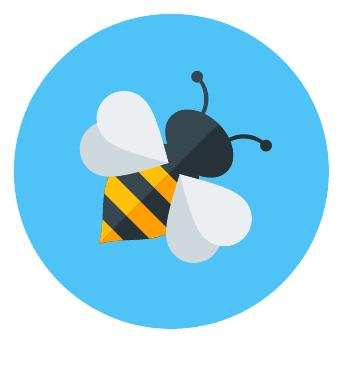

In [8]:
res_input.additional_metadata